In [154]:
import taichi as ti
import numpy as np
import math
from sympy import inverse_mellin_transform
from pyevtk.hl import gridToVTK
import pandas as pd
import matplotlib.pyplot as plt
import os
import argparse
import random

plt.rcParams['font.family'] = 'DeJavu Serif' 
plt.rcParams["font.serif"] = "Times New Roman"
ti.init(arch=ti.cpu, flatten_if=True)

dim = 2
Q = 9 
real = ti.f32
i32_vec2d = ti.types.vector(2, ti.i32)
f32_vec2d = ti.types.vector(2, ti.f32)
scalar_real = lambda: ti.field(dtype=real)
scalar_int = lambda: ti.field(dtype=ti.i32)
vec = lambda: ti.Vector.field(dim, dtype=real)
vec_Q = lambda: ti.Vector.field(Q, dtype=real)

# Input paramters
ly = 200
lx = 200
x = np.linspace(0, lx)
y = np.linspace(0, ly)
X, Y = np.meshgrid(x, y, indexing="ij")
IniPerturbRate = 1
rho0 = 1.
rhos = 3.
carn_star = False
T_Tc = 0.7
G = -1.0
tau = 1.  # specify the relaxaton time (only for BGK operator)
inv_tau = 1/tau
A = tau

dp = scalar_real() # pressure at left
loss = scalar_real()
sum_v = scalar_real()
sum_rho = scalar_real()

is_solid = scalar_int()

v = vec()

temp_v = vec()
target_v =  vec() # target velocity field
rho = scalar_real()

collide_f = vec_Q()
stream_f = vec_Q()

ti.root.dense(ti.ij, (lx, ly)).place(is_solid)
ti.root.dense(ti.ij, (lx, ly)).place(target_v)
ti.root.dense(ti.ij, (lx, ly)).place(rho,v,temp_v)
ti.root.dense(ti.ij, (lx, ly)).place(collide_f,stream_f)

ti.root.place(dp, loss,sum_v,sum_rho)

ti.root.lazy_grad()

"""Definition of LBM parameters"""
half = (Q - 1) // 2
# LBM weights
w0 = 4.0 / 9.0
w1 = 1.0 / 36.0
w2 = 1.0 / 9.0
w_np = np.array([w0, w1, w2, w1, w2, w1, w2, w1, w2])

# x component of predefined velocity in Q directions
e_xy_list = [
    [0, 0],
    [-1, 1],
    [-1, 0],
    [-1, -1],
    [0,-1],
    [1, -1],
    [1, 0],
    [1, 1],
    [0, 1],
]

# reversed_e_xy_np stores the index of the opposite component to every component in e_xy_np
# For example, for [1,0,0], the opposite component is [-1,0,0] which has the index of 2 in e_xy
reversed_e_index = np.array([e_xy_list.index([-a for a in e]) for e in e_xy_list])

w = ti.field(ti.f32,shape=Q)
w.from_numpy(w_np)
e_xy = ti.Vector.field(n=2, dtype=ti.i32, shape=Q)
e_xy.from_numpy(np.array(e_xy_list))
ti.static(e_xy)
ti.static(w)

# Writing input model (here we make a grain sample
def place_sphere(x, y, R):
    global solid_count
    
    xmin = x - R
    ymin = y - R
    xmax = x + R
    ymax = y + R

    for px in range(xmin, xmax + 1):
        for py in range(ymin, ymax + 1):
            dx = px - x
            dy = py - y
        
            dist2 = dx * dx + dy * dy 
            R2 = R * R
            if dist2 < R2:
                near_px = (
                    math.floor(px + 0.5)
                    if math.floor(px + 0.5)
                    else math.floor(px + 0.5) + lx
                )
                near_py = (
                    math.floor(py + 0.5)
                    if math.floor(py + 0.5)
                    else math.floor(py + 0.5) + ly
                )
                
                if near_px >= lx:
                    near_px -= lx
                if near_py >= ly:
                    near_py -= ly
                
                if is_solid[near_px, near_py]==0:
                    is_solid[near_px, near_py] = 1
                    solid_count +=1


def read_positions(position_filename,reduced_R = True):
    global mean_dia,nb_grains
    i = 0
    reduced = 1.
    with open(position_filename) as f:
        Lines = f.readlines()
    for line in Lines:
        if reduced_R:
            reduced = random.random()/10+0.9
        i += 1
        k = float(line)
        k = int(k)
        if i == 1:
            x = k
        elif i == 2:
            y = k
        
        else:
            i = 0
            r = int(max(k * reduced,k-1))
            if (y <= ly-r):
                place_sphere(x, y, r)
                mean_dia +=2*r
                nb_grains +=1
    mean_dia /=nb_grains

os.chdir('./')
position_file = './positions_n375_res200_2d_random'
solid_count = nb_grains = mean_dia = 0

read_positions(position_file,reduced_R=True)
mean_dia /=10000 #mm to m

psolid_count = 0
for j in range(ly):
    if is_solid[0,j]==1:
        is_solid[0,j] = 0
        psolid_count +=1
    if is_solid[lx-1,j] == 1:
        is_solid[lx-1,j] = 0
        psolid_count +=1

for i in range(lx):
    if is_solid[i,0]==0:
        is_solid[i,0]=1
        solid_count +=1
    if is_solid[i,ly-1]==0:
        is_solid[i,ly-1]=1
        solid_count +=1

porosity = 1-solid_count/lx/ly

print(solid_count,mean_dia,porosity)

ti.static(is_solid)

[Taichi] Starting on arch=x64
20991 0.0011824742268041239 0.475225


<ti.field>

In [155]:
def dPress(rho_value,carn_star=False):
    if carn_star:
        a = 1.0
        b = 4.0
        R = 1.0
        Tc = 0.0943
        T = T_Tc * Tc
        eta = b * rho_value / 4.0
        eta2 = eta * eta
        eta3 = eta2 * eta
        rho2 = rho_value * rho_value
        one_minus_eta = 1.0 - eta
        one_minus_eta3 = one_minus_eta * one_minus_eta * one_minus_eta

        return rho_value * R * T * (1 + eta + eta2 - eta3) / one_minus_eta3 - a * rho2
    else:
        cs2 = 1.0 / 3.0
        psi = 1.0 - np.exp(-rho_value)
        psi2 = psi * psi
        return cs2 * rho_value + cs2 * G / 2 * psi2
    
@ti.func
def periodic_index(i):
    iout = i
    if i[0]<0:     iout[0] = lx-1
    if i[0]>lx-1:  iout[0] = 0
    if i[1]<0:     iout[1] = ly-1
    if i[1]>ly-1:  iout[1] = 0

    return iout

@ti.func
def velocity_vec(local_pos) -> f32_vec2d:
    velocity_vec = ti.Vector([0., 0.])    
    for i in ti.static(range(2)):
        for s in ti.static(range(Q)):
            velocity_vec[i] = velocity_vec[i] + (stream_f[local_pos][s]* e_xy[s][i])
        velocity_vec[i] = velocity_vec[i]/rho[local_pos]

    return velocity_vec

@ti.func
def feq_p(k,rho_local, u): # anti bounce-back pressue bound
    eu = e_xy[k].dot(u)
    uv = u.dot(u)
    feqout = 2*w[k]*rho_local*(1.0+4.5*eu*eu-1.5*uv)
    return feqout

@ti.kernel
def init_field():
    for x, y in ti.ndrange(lx, ly):
        rho[x,y] = rhos
        v[x,y] = ti.Vector([0., 0.])
        collide_f[x,y] = ti.Vector([0.,0.,0.,0.,0.,0.,0.,0.,0.])
        stream_f[x,y] = ti.Vector([0., 0.,0., 0.,0., 0.,0., 0.,0.])

        if is_solid[x,y] <= 0:
            rho[x,y] = rho0
            for q in ti.static(range(Q)):
                collide_f[x,y][q] = w[q] * rho[x,y]
                stream_f[x,y][q] = w[q] * rho[x,y]      

@ti.kernel
def collision():
    for I in ti.grouped(collide_f):
        if (I.x < lx and I.y<ly and is_solid[I] <= 0):            
            """BGK operator"""
            v[I] = velocity_vec(I)
            u_squ = v[I].dot(v[I])
            for s in ti.static(range(Q)):
                eu = e_xy[s].dot(v[I])
                collide_f[I][s] = collide_f[I][s] + (w[s] * rho[I] *(1.0 + 3.0 * eu \
                    + 4.5 * eu * eu - 1.5 * u_squ) -collide_f[I][s]) *inv_tau

@ti.kernel
def post_collsion():
    for I in ti.grouped(collide_f):
        if (I.x < lx and I.y<ly and is_solid[I] <= 0):
            collide_f[I] = stream_f[I]
            rho[I] = collide_f[I].sum()

@ti.kernel
def boundary_condition():   
    for I in ti.grouped(v):
        if (I.x < lx and I.y<ly and is_solid[I]<=0):
            for s in ti.static(range(Q)):
                neighbor_pos = periodic_index(I+e_xy[s])
                if (e_xy[s][0] == 1 and I.x==0):
                    stream_f[I][s] = feq_p(s, dp[None], v[I])- collide_f[I][reversed_e_index[s]]

                if (e_xy[s][0] == -1 and I.x==lx-1):
                    stream_f[I][s]= feq_p(s, rho0, v[I])- collide_f[I][reversed_e_index[s]]
    
    for I in ti.grouped(v):
        if (I.x < lx and I.y<ly and is_solid[I] <= 0): 
            rho[I] = stream_f[I].sum()
            collide_f[I] = stream_f[I] 

@ti.kernel
def streaming():
    for I in ti.grouped(collide_f):
        if (I.x < lx and I.y<ly and is_solid[I] <= 0):
            for s in ti.static(range(Q)):
                neighbor_pos = periodic_index(I+e_xy[s])
                if (is_solid[neighbor_pos]<=0):
                    stream_f[neighbor_pos][s] = collide_f[I][s]
                else:
                    stream_f[I][reversed_e_index[s]] = collide_f[I][s]  

def export_VTK(n):
        is_solid_3d = np.ascontiguousarray(is_solid.to_numpy()[0:lx,0:ly]).reshape(lx,ly,1)
        rho_3d = np.ascontiguousarray(rho.to_numpy()[0:lx,0:ly]).reshape(lx,ly,1)
        v_ = v.to_numpy()[0:lx,0:ly,:]
        v_3d = v_[0:lx,0:ly,np.newaxis,:]
#         p_3d = np.ascontiguousarray(pressure.to_numpy()[0:lx,0:ly]).reshape(lx,ly,1)

        max_rho = 0
        max_vx = 0
        max_vy = 0
        for i in range(lx):
            for j in range(ly):
                if is_solid_3d[i,j,0]<=0:
                    if rho_3d[i,j,0]>max_rho:
                        max_rho=rho_3d[i,j,0]
                    if v_[i,j,0] > max_vx:
                        max_vx = v_[i,j,0]
                    if v_[i,j,1] > max_vy:
                        max_vy = v_[i,j,1]
        
        grid_x = np.linspace(0, lx, lx)
        grid_y = np.linspace(0, ly, ly)
        # X, Y, Z= np.meshgrid(x, y, np.zeros(1), indexing='ij')
        z = np.array([0.0])

        gridToVTK(
                "./LB_SingelPhase_"+str(n),
                grid_x,
                grid_y,
                z,
                pointData={ "Solid": is_solid_3d,
                            "rho": rho_3d,
#                             "pressure": p_3d,
                            "velocity": (np.ascontiguousarray(v_3d[:,:,:,0]),
                                         np.ascontiguousarray(v_3d[:,:,:,1]),
                                         np.ascontiguousarray(v_3d[:,:,:,0]),
                                            )
                            }
            )  

@ti.kernel
def update_vel():
    for I in ti.grouped(v): 
        v[I] = velocity_vec(I)

def run(max_step=1000,compute_loss=True):
    step = 0
    init_field()
    while step < max_step:  
        boundary_condition()
        collision() 
        streaming()
        step +=1 
        if step%50 == 0:
            export_VTK(step//50)
    
    if compute_loss:
        update_vel()
        for i in range(lx):
            for j in range(ly):
                target_v[i,j] = v[i,j]

@ti.kernel
def compute_loss():  
    for I in ti.grouped(rho): 
        if (I.x < lx and I.y<ly and is_solid[I]<=0):
            for i in ti.static(range(2)):
                temp_v[I][i]=0.
                for s in ti.static(range(Q)):
                    temp_v[I][i] = temp_v[I][i] + (stream_f[I][s]* e_xy[s][i])
                temp_v[I][i] = temp_v[I][i]/rho[I] 
                
            loss[None]+= (target_v[I].norm()-temp_v[I].norm())**2
            #loss[None]+= (temp_v[I].x-target_v[I].x)**2
            sum_v[None]+=temp_v[I].x
            if I.x !=0 and I.x!=lx-1:
                sum_rho[None] +=rho[I]
        

In [168]:
##set target velocity field 
loss[None] = sum_v[None] = sum_rho[None]=0.
dp[None] = 2.

pressure_gradient = (dPress(dp[None])-dPress(rho0))/lx

target_p = dp[None]
run(max_step=5000)
print(loss[None])
compute_loss()

0.0


In [175]:
mean_v =sum_v[None]/(lx*ly-solid_count)
mean_rho = sum_rho[None]/(lx*ly-solid_count)

viscosity_lbm = 0. # Not converted yet 
viscosity_real = 1e-3 # Pa. s # viscosity of water at 20 C (Pascal seconds)

# Unit conversion 1:
lu_to_m = 1e-4 # 1 lu = 1e-4 m

def calc_k(mean_v,mean_rho,pressure_gradient):
    kviscosity_lbm = 1/6 
    kviscosity_real = 1e-6 # kinematic viscosity of water at 20 C
    
    # Unit conversion 2:
    mu_to_kg= 1000*lu_to_m**3/mean_rho # 1 mu = ?? kg 
    ts_to_s = kviscosity_lbm/kviscosity_real*lu_to_m**2 # 1 ts =  ?? second
    
    pressure_lbm_to_Pa = mu_to_kg/lu_to_m/(ts_to_s**2)  # 1 pressure_lbm = ?? Pa
    print(ts_to_s,mu_to_kg,pressure_lbm_to_Pa)
    kviscosity_lbm_to_m2Ps = kviscosity_real/kviscosity_lbm # 1 v_lbm = ?? m2/s2 

    # Pair of variables:
    mean_v_lbm = mean_v
    mean_v_real = mean_v*(lu_to_m/ts_to_s)
    cylinder_diameter_lbm = lx/2
    cylinder_diameter_real = cylinder_diameter_lbm*lu_to_m
    pressure_gradient_lbm = pressure_gradient
    pressure_gradient_real = pressure_gradient_lbm*pressure_lbm_to_Pa/lu_to_m
    mean_dia_lbm = mean_dia
    mean_dia_real = mean_dia_lbm*lu_to_m
        
    Reynolds_real = mean_v_real*cylinder_diameter_real/kviscosity_real
    Reynolds_lbm = mean_v_lbm*cylinder_diameter_lbm/kviscosity_lbm
    print(Reynolds_real,Reynolds_lbm,mean_v_lbm,mean_v_real)
    
    #https://neutrium.net/fluid-flow/packed-bed-reynolds-number/
    #Reynolds_lbm = mean_dia_lbm*mean_v_lbm/(kviscosity_lbm*(1-porosity))
    #Reynolds_real = mean_dia_real*mean_v_real/(kviscosity_real*(1-porosity))
    #print(Reynolds_real,Reynolds_lbm)

    k_lbm = mean_v_lbm*porosity/pressure_gradient_lbm*kviscosity_lbm*mean_rho
    k_real = mean_v_real*porosity/pressure_gradient_real*kviscosity_real*1000
    
    return k_real,mean_v_real,pressure_gradient_real

print(calc_k(mean_v,mean_rho,pressure_gradient))

0.0016666666666666666 6.960470971028029e-10 2.5057695495700907
2.5157327434743086 2.5157327434743086 0.004192887905790514 0.00025157327434743084
(3.465867142875189e-09, 0.00025157327434743084, 34.494660174013234)


In [179]:
dPress(1.2)

0.3186117450891653

In [79]:
from IPython.display import display, Latex
display(Latex('${\displaystyle \kappa ={\mathit {\Phi }}_{\mathrm {s} }^{2}{{\epsilon ^{3}D_{\mathrm {p} }^{2}}/({180(1-\epsilon )^{2}}}})$'))

<IPython.core.display.Latex object>

In [177]:
porosity_ = 1-(solid_count-psolid_count)/lx/ly

ck_K = porosity_**3*(mean_dia)**2/(180*(1-porosity_)**2)
ck_K

3.2075387092063766e-09

In [114]:
"""Success"""
# initial value of dp
dp[None] = 1.2
learning_rate =  0.001
loss.grad[None] = 1.
init_p = dp[None]
init_loss = 0
pre_loss = 0

# Arrays of deriavtives 
dp_array = []
loss_array = []
mean_vs = []
mean_rhos = []

for iteration in range(100):
    init_field()
    for step in range(5000):
        with ti.ad.Tape(loss):
            boundary_condition()
            collision() 
            streaming()
            sum_v[None] = 0.
            sum_rho[None] = 0.
            compute_loss()
            
    
    loss_array.append(loss[None])
    pressure_gradient = (dPress(dp[None])-dPress(rho0))/lx
    mean_v =sum_v[None]/(lx*ly-solid_count)
    mean_rho = sum_rho[None]/(lx*ly-solid_count)
    
    dp_array.append(pressure_gradient)
    mean_vs.append(mean_v)
    mean_rhos.append(mean_rho)
    
    print("dloss/ddp = {}, dp = {}, loss = {} at no. {} iteriation.".format(dp.grad[None],dp[None],loss[None],iteration))
    
    if iteration ==0:
        init_loss = loss[None]
        dp[None] -= dp.grad[None] * learning_rate
    else:
        dp[None] -= dp.grad[None] * learning_rate*(loss[None]-pre_loss)/abs(loss[None]-pre_loss)
    
    pre_loss = loss[None]
    pre_grad = dp.grad[None]

dloss/ddp = -435.0464782714844, dp = 1.2000000476837158, loss = 4.8802385330200195 at no. 0 iteriation.
dloss/ddp = 19.206575393676758, dp = 1.6350464820861816, loss = 0.9139912724494934 at no. 1 iteriation.
dloss/ddp = 24.288576126098633, dp = 1.6542530059814453, loss = 0.8176025152206421 at no. 2 iteriation.
dloss/ddp = 29.51909828186035, dp = 1.6785415410995483, loss = 0.7038862109184265 at no. 3 iteriation.
dloss/ddp = 34.170902252197266, dp = 1.708060622215271, loss = 0.5777698755264282 at no. 4 iteriation.
dloss/ddp = 37.3617057800293, dp = 1.7422314882278442, loss = 0.4480331540107727 at no. 5 iteriation.
dloss/ddp = 38.34056854248047, dp = 1.7795932292938232, loss = 0.3257408142089844 at no. 6 iteriation.
dloss/ddp = 36.817626953125, dp = 1.8179337978363037, loss = 0.22105371952056885 at no. 7 iteriation.
dloss/ddp = 33.12168884277344, dp = 1.854751467704773, loss = 0.13998188078403473 at no. 8 iteriation.
dloss/ddp = 28.05611228942871, dp = 1.8878731727600098, loss = 0.0830563

KeyboardInterrupt: 

In [115]:
ks,real_mean_v,real_dp = calc_k(np.array(mean_vs),np.array(mean_rhos),np.array(dp_array))
print(ks)

0.0016666666666666666 [8.86685130e-10 7.71802760e-10 7.67408467e-10 7.61921821e-10
 7.55358113e-10 7.47899469e-10 7.39910774e-10 7.31887957e-10
 7.24345755e-10 7.17692137e-10 7.12150838e-10 7.07757783e-10
 7.04411612e-10 7.01940710e-10 7.00158562e-10 6.98894420e-10
 6.98009184e-10 6.97394236e-10 6.96969582e-10 6.96677973e-10
 6.96477854e-10 6.96341118e-10 6.96247516e-10 6.96183618e-10
 6.96139998e-10 6.96110571e-10] [3.19206647 2.77848994 2.76267048 2.74291855 2.71928921 2.69243809
 2.66367879 2.63479665 2.60764472 2.58369169 2.56374302 2.54792802
 2.5358818  2.52698656 2.52057082 2.51601991 2.51283306 2.51061925
 2.5090905  2.5080407  2.50732027 2.50682802 2.50649106 2.50626103
 2.50610399 2.50599806]
[0.65136798 1.78774438 1.83053742 1.88387643 1.9475577  2.01974416
 2.0968437  2.17403669 2.24638257 2.31001795 2.36287498 2.40468731
 2.43648007 2.45992213 2.47681789 2.48878949 2.49716934 2.50298958
 2.50700564 2.50976561 2.51165793 2.51295303 2.51383705 2.51444005
 2.5148516  2.515132

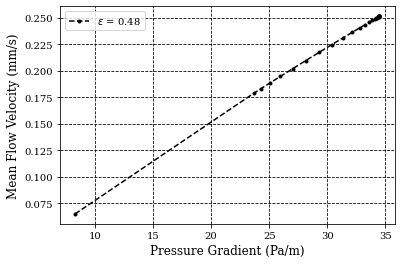

In [134]:
plot_curves([real_dp],[real_mean_v*1000],xlabel='Pressure Gradient (Pa/m)',
    ylabel='Mean Flow Velocity (mm/s)',
    xlim=None,
    ylim=None,
    labels=[r'$\epsilon$ = 0.48'],
    colors=['black'],
    label_loc=None,
    save_fig=True,
    yscale=None,
    line_style=['--'],
    marker_style=['o',''],)

In [117]:
def plot_curves(
    x,
    y,
    xlabel=None,
    ylabel=None,
    xlim=None,
    ylim=None,
    labels=None,
    colors=None,
    label_loc=None,
    save_fig=False,
    yscale=None,
    line_style=None,
    marker_style=['',''],
):

    if not labels:
        labels = []
        for i in range(len(x)):
            labels.append(i + 1)

    if line_style is not None:
        if colors:
            for i in range(len(x)):
                plt.plot(
                    x[i],
                    y[i],
                    linestyle=line_style[i],
                    marker=marker_style[i],
                    markersize=3,
                    color=colors[i],
                )
        else:
            for i in range(len(x)):
                plt.plot(x[i], y[i], linestyle=line_style[i], marker="o", markersize=2)
    else:
        if colors:
            for i in range(len(x)):
                plt.plot(
                    x[i], y[i], linestyle="-", marker="o", markersize=2, color=colors[i]
                )
        else:
            for i in range(len(x)):
                plt.plot(x[i], y[i], linestyle="-", marker="o", markersize=2)

    plt.legend(labels, fontsize=10)

    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.ylabel(ylabel, fontsize=12)
    plt.xlabel(xlabel, fontsize=12)
    plt.grid(True, color="k", linestyle="--")

    if save_fig:
        plt.savefig("2d_permeability", bbox_inches="tight", dpi=150)

In [135]:
target_loss = 0

final_index = min(range(len(loss_array)), key=lambda i: abs(loss_array[i]-target_loss))
init_p_diff = dPress(init_p,carn_star=False)- dPress(rho0,carn_star=False)

target_p_diff = dPress(target_p,carn_star=False)- dPress(rho0,carn_star=False)

pressure_diff = [p*lx for p in dp_array]

init_p_diff = real_dp[0]*lx/10000
target_p_diff = real_dp[-1]*lx/10000
pressure_diff = real_dp*lx/10000

print(init_p_diff,target_p_diff,pressure_diff)

0.16558682363570132 0.6897059699462825 [0.16558682 0.4730625  0.48530053 0.50063509 0.51906331 0.54011541
 0.56279733 0.58571736 0.60739577 0.62662691 0.64271998 0.65552859
 0.66531529 0.67255826 0.67779199 0.68150753 0.68411291 0.68592339
 0.68717365 0.68803354 0.68862302 0.68902644 0.68930199 0.68949011
 0.68961827 0.68970597]


In [147]:
dPress(1.)

0.266737266517712

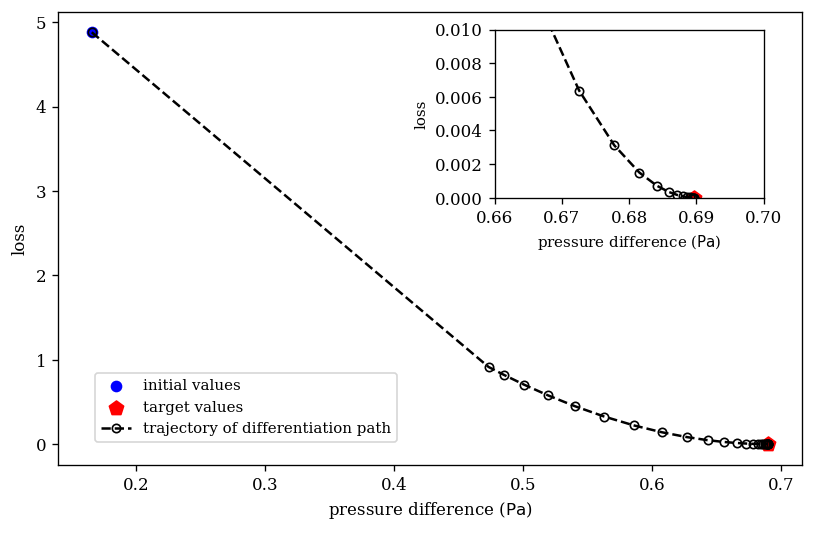

In [146]:
plt.rcParams['font.family'] = 'DeJavu Serif' 
plt.rcParams["font.serif"] = "Times New Roman"


fig,ax1 = plt.subplots(figsize=(8,5),dpi=120)
# ax1.set_xlim(0.99, 1.61)
# ax1.set_ylim(400, 1200)


ax1.scatter(init_p_diff,init_loss,color='blue',label = 'initial values')

ax1.scatter(target_p_diff,target_loss,color='red',label = 'target values',marker='p', s=80)

ax1.plot(pressure_diff, loss_array, linestyle='--',marker='o', markersize=5, 
markerfacecolor='none',color='black',label = 'trajectory of differentiation path')
# ax1.set_xlim([0.0,0.09])
# ax1.set_ylim([0, 120])

# plt.xlabel(r'pressure difference ($\rm mu·lu^{-1}t^{-2}$)', fontsize=10)
plt.xlabel(r'pressure difference ($\rm Pa$)', fontsize=10)
plt.ylabel('loss', fontsize=10)

left, bottom, width, height = [0.58, 0.57, 0.28, 0.28]
ax2 = fig.add_axes([left, bottom, width, height])

ax2.scatter(target_p_diff,target_loss,color='red',label = 'target values',marker='p', s=80)

ax2.plot(pressure_diff, loss_array, linestyle='--',marker='o', markersize=5, 
markerfacecolor='none',color='black',label = 'trajectory of differentiation path')
ax2.set_xlim([0.66, 0.7])
ax2.set_ylim([-0.00, 0.01])

ax1.legend(fontsize=9,loc=(0.05,0.05))
plt.xlabel(r'pressure difference ($\rm Pa$)', fontsize=9)
plt.ylabel('loss', fontsize=9)
plt.show()    